# Automated Trading Tester
This notebook loads a crypto currancy chart and performs a "trade run" by simulate buying and selling with the goal to optimize profit in a virtual wallet. To this end, different parameters can be used to define buy and sell signals. In the end, the profit is compared to a benchmark run which is calculated separatly. The benchmark assumes that one buys on the first price of the chart and sells at the last price of the chart. Thus, it simply reflects the development of the crypto currancy.  

In [1]:
# Import python libraries
from statistics import mean
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from IPython import display
%matplotlib inline

## Define trading parameters
The trade run is parameterized by several parameters which influence the buy and sell behavior. The parameters are summarized in a class whose instance is injected into the wallet.

In [2]:
class Parameters:
    def __init__(self):
        '''
        Description:
        Creates a set of trading parameters.
        ''' 
        self.trading_charge_fraction = 0.005
        self.stop_loss_fraction = 0.85
        self.mean_average_buy_fraction = 0.9
        self.mean_average_filter_length = 5
        
    def get_trading_charge_fraction(self):
        return self.trading_charge_fraction

    def get_stop_loss_fraction(self):
        return self.stop_loss_fraction

    def get_mean_average_buy_fraction(self):
        return self.mean_average_buy_fraction

    def get_mean_average_filter_length(self):
        return self.mean_average_filter_length


## Creation of a class for the (simulated) real-time crypto chart
The chart of the crypro currancy is loaded from a csv file. Initiated chart objects can be checked for the current or the next price. Checking for the next price is like updating a real-time chart.

In [3]:
class RealTimeChart:
    def __init__(self, path):
        '''
        INPUT:
        path - Path to a crypto chart file
    
        Description:
        Creates a new chart based on a loaded crypto chart
        ''' 
        self.df = pd.read_csv(path, skiprows=[0])  # Read file with chart
        self.df = self.df.sort_values(by=['Date']) # Since it is in a reverse order, sort the chart ascendingly
        self.df = self.df.reset_index(drop=True)   # Reset old index
        
        # Set the index to 0
        self.index = 0
        
    def reset_index(self):
        '''    
        Description:
        Sets index to 0 which is necessary if the chart shall be used for another "trade run"
        ''' 
        self.index = 0

    def visualize(self):
        '''
        Description:
        Simply plots the whole chart
        '''
        plt.plot(self.df['Open'])
        return self.df.head(10)
        
    def get_current_price(self):
        '''
        OUTPUT:
        Current price
        
        Description:
        Return the current price.
        '''
        price = self.df.at[self.index, 'Open']
        return price

    def get_next_price(self):
        '''
        OUTPUT:
        Next price (which is then the new current price)
        
        Description:
        Return the next price. Can be used to simulate a real-time price.
        '''
        self.index+=1
        if self.index > (self.df.shape[0] - 1):
            price = 0
        else:
            price = self.df.at[self.index, 'Open']
        return price
    
    def has_next_price(self):
        '''
        OUTPUT:
        True if there is another price
        
        Description:
        Returns True if there is another price in the chart (False if not).
        '''
        if (self.index + 1) > (self.df.shape[0] - 1):
            return False
        else:
            return True
        
    def get_date(self):
        '''
        OUTPUT:
        date
        
        Description:
        Returns the current date (timestamp).
        '''
        date = self.df.at[self.index, 'Date']
        return date


## Creation of a virtual wallet
A wallet object contains money in a fiat and a crypto currancy. Buying and selling simply converts from fiat into crypto and vice versa for a given price.

In [4]:
class Wallet:
    def __init__(self, fiat):
        '''
        INPUT:
        fiat - Initial budget in FIAT currancy
    
        Description:
        Creates a new wallet with an initial budget
        ''' 
        self.fiat = fiat
        self.crypto = 0

    def buy_crypto(self, amount, price, charge_fee_percentage):
        '''
        INPUT:
        amount - Units of crypto currency to be bought
        price - Current price of crypto currancy in FIAT
        charge_fee_percentage - Charge fee (percentage value which is subtracted from amount value)

        Description:        
        Buy a defined amount of a crypto currancy.
        Returns True if order was successful (False if not)
        ''' 
        if (amount * price) <= self.fiat:
            self.fiat = self.fiat - (amount * price)
            self.crypto = self.crypto + (amount - (amount * charge_fee_percentage))
            print(amount, "crypto units bought for unit price of", price, "FIAT (Overall price:", amount * price, "FIAT)")
            print("Charge fee: ", (charge_fee_percentage * 100), "% ->", (amount - (amount * charge_fee_percentage)), "new crypto units in wallet")
            return True
        else:
            return False
        
    def buy_crypto_for(self, budget, price, charge_fee_percentage):
        '''
        INPUT:
        budget - Budget for which crypto currency shall be bought
        price - Current price of crypto currancy in FIAT
        charge_fee_percentage - Charge fee (percentage value which is subtracted from amount value)

        Description:        
        Buy crypto currancy  fir a defined budget.
        Returns True if order was successful (False if not)
        ''' 
        if budget <= self.fiat:
            self.fiat = self.fiat - budget
            self.crypto = self.crypto + (budget / price) - ((budget / price) * charge_fee_percentage)
            print("Crypto units bought for budget of", budget, "FIAT (Unit price: ", price, ")")
            print("Charge fee: ", (charge_fee_percentage * 100), "% ->", (budget / price) - ((budget / price) * charge_fee_percentage), "new crypto units in wallet")
            return True
        else:
            return False
        
    def sell_crypto(self, amount, price, charge_fee_percentage):
        '''
        INPUT:
        amount - Units of crypto currency to be sold
        price - Current price of crypto currancy in FIAT
        charge_fee_percentage - Charge fee (percentage value which is subtracted from overall sales price)

        Description:        
        Sells a defined amount of a crypto currancy.
        Returns True if order was successful (False if not)
        '''
        if amount <= self.crypto:
            self.crypto = self.crypto - amount
            self.fiat = self.fiat + ((amount * price) - (amount * price * charge_fee_percentage))
            print(amount, "crypto units sold for unit price of", price, "FIAT (Overall price:", amount * price, "FIAT)")
            print("Charge fee: ", (charge_fee_percentage * 100), "% ->", ((amount * price) - (amount * price * charge_fee_percentage)), "new FIAT units in wallet")
            return True
        else:
            return False
    
    def sell_crypto_for(self, budget, price, charge_fee_percentage):
        '''
        INPUT:
        budget - Budget (in FIAT currency) of crypto currency to be sold
        price - Current price of crypto currancy in FIAT
        charge_fee_percentage - Charge fee (percentage value which is subtracted from overall sales price)

        Description:        
        Sells a defined budget in FIAT currency of a crypto currancy.
        Returns True if order was successful (False if not)
        '''
        if (budget / price) <= self.crypto:
            return True
            self.crypto = self.crypto - (budget / price)
            self.fiat = self.fiat + budget - (budget * charge_fee_percentage)
            print("Crypto units sold for budget of", budget, "FIAT (Unit price: ", price, ")")
            print("Charge fee: ", (charge_fee_percentage * 100), "% ->", budget - (budget * charge_fee_percentage), "new FIAT units in wallet")
        else:
            return False
        
    
    def get_fiat(self):
        '''
        OUTPUT:
        fiat - value of fiat money in wallet
        
        Description:
        Returns current number of euros.
        '''
        return self.fiat

    def get_crypto(self):
        '''
        OUTPUT:
        crypto - value of crypto money in wallet
        
        Description:
        Returns current units of crypto currancy.
        '''
        return self.crypto

    def get_value(self, price):
        '''
        INPUT:
        price - Current price of crypto currancy in FIAT 
        
        OUTPUT:
        value - Current value of the wallet
        
        Description:
        Calculates the value of the wallet by adding value of crypto units with FIAT.
        '''
        return self.fiat + (self.crypto * price)
    
    def to_string(self, price):
        print("----------------")
        print("FIAT: ", self.fiat)
        print("CRYP: ", self.crypto, "->", self.crypto * price, "FIAT")
        print("SUM: ", self.get_value(price), "(FIAT)")
        print("----------------")


## Trader
A Trader object performs a trade run for a given real-time chart, a wallet, and a set of trading parameters. There is the option to perform a benchmark run to compare it with a specific algorithm. The benchmark assumes that one buys on the first price of the chart and sells at the last price of the chart. Thus, it simply reflects the development of the crypto currancy. 

In [5]:
class Trader:
    def __init__(self, wallet, parameters, real_time_chart):
        self.wallet = wallet
        self.parameters = parameters
        self.real_time_chart = real_time_chart

    def run_benchmark(self):
        '''
        OUTPUT:
        history - Complete value history of a run
    
        Description:
        Performs a benchmark run which follows to the development of the chart (minus trade charge)
        '''
        
        # Reset index of the chart (to ensure to start from the beginning)
        self.real_time_chart.reset_index()

        date = []
        price = []
        wallet_value = []

        current_price = self.real_time_chart.get_current_price()
        date.append(self.real_time_chart.get_date())
        price.append(current_price)
        wallet_value.append(self.wallet.get_value(current_price))
        
        # Buy
        self.wallet.to_string(current_price)
        self.wallet.buy_crypto_for(self.wallet.get_fiat(), self.real_time_chart.get_current_price(), self.parameters.get_trading_charge_fraction())
        self.wallet.to_string(self.real_time_chart.get_current_price())
        
        # Run through chart
        while self.real_time_chart.has_next_price():
            self.real_time_chart.get_next_price()
            current_price = self.real_time_chart.get_current_price()
            date.append(self.real_time_chart.get_date())
            price.append(current_price)
            wallet_value.append(self.wallet.get_value(current_price))
            
        history = pd.DataFrame(list(zip(date, price, wallet_value)), columns =['Date', 'Price', 'Wallet_Value'])            
            
        # Sell    
        self.wallet.sell_crypto(self.wallet.get_crypto(), self.real_time_chart.get_current_price(), self.parameters.get_trading_charge_fraction())
        self.wallet.to_string(self.real_time_chart.get_current_price())
        
        return history

    def run(self):
        '''
        OUTPUT:
        history - Complete value history of a run
    
        Description:
        Performs a trade run based on a trading algorithm with to goal to maximize profit 
        '''

        # Reset index of the chart (to ensure to start from the beginning)
        self.real_time_chart.reset_index()

        date = []
        price = []
        wallet_value = []
        stop_loss_limit = 0
        sum_of_last_prices = 0
        i = 0

        current_price = self.real_time_chart.get_current_price()
        date.append(self.real_time_chart.get_date())
        price.append(current_price)
        wallet_value.append(self.wallet.get_value(current_price))
        
        # Initial buy
        self.wallet.to_string(current_price)
        self.wallet.buy_crypto_for(self.wallet.get_fiat(), self.real_time_chart.get_current_price(), self.parameters.get_trading_charge_fraction())
        stop_loss_limit = self.real_time_chart.get_current_price() * self.parameters.get_stop_loss_fraction()
        print("Stop loss limit is at", self.real_time_chart.get_current_price() * self.parameters.get_stop_loss_fraction())
        self.wallet.to_string(self.real_time_chart.get_current_price())
        
        # Run through chart
        while self.real_time_chart.has_next_price():
            self.real_time_chart.get_next_price()
            current_price = self.real_time_chart.get_current_price()
            date.append(self.real_time_chart.get_date())
            price.append(current_price)
            wallet_value.append(self.wallet.get_value(current_price))
            
            # Raise stop loss limit if there is growth
            if (stop_loss_limit / self.parameters.get_stop_loss_fraction()) < current_price and self.wallet.get_crypto() > 0:
                stop_loss_limit = current_price * self.parameters.get_stop_loss_fraction()
                print("Current price is", current_price, " -> Increase stop loss limit to", stop_loss_limit)
            
            # Check for sell signal
            if(stop_loss_limit > current_price):
                if self.wallet.get_crypto() > 0:
                    print("--- SELL SIGNAL: Stop loss limit undershoot at ", self.real_time_chart.get_date(), "---")
                    self.wallet.sell_crypto(self.wallet.get_crypto(), current_price, self.parameters.get_trading_charge_fraction())
                    
            # Calculate mean average
            sum_of_last_prices = sum_of_last_prices + current_price
            if i >= self.parameters.get_mean_average_filter_length():
                sum_of_last_prices = sum_of_last_prices - price[i - self.parameters.get_mean_average_filter_length()]
                mean_average = sum_of_last_prices / self.parameters.get_mean_average_filter_length()
                    
                # Check for buy signal
                if self.wallet.get_fiat() > 0:
                    if current_price < mean_average * self.parameters.get_mean_average_buy_fraction():
                        print("--- BUY SIGNAL: Price below mean average fraction limit of", mean_average, "at", self.real_time_chart.get_date(), "---")
                        self.wallet.buy_crypto_for(self.wallet.get_fiat(), current_price, self.parameters.get_trading_charge_fraction())
                        stop_loss_limit = current_price * self.parameters.get_stop_loss_fraction()
            
            # Increment counter
            i += 1
            
        history = pd.DataFrame(list(zip(date, price, wallet_value)), columns =['Date', 'Price', 'Wallet_Value'])            
            
        # Sell remaining crypto currancy    
        self.wallet.sell_crypto(self.wallet.get_crypto(), self.real_time_chart.get_current_price(), self.parameters.get_trading_charge_fraction())
        self.wallet.to_string(self.real_time_chart.get_current_price())
        
        return history


In [6]:
# Helper function to calculate the growth
def calc_growth(df):
    '''
    INPUT
    df - Data frame to be analyzed
    
    Description:
    Prints growth over the time in percentage.
    '''
    print("Open:", df.at[0, 'Wallet_Value'])
    print("Close:", df.at[df.shape[0] - 1, 'Wallet_Value'])
    growth = ((df.at[df.shape[0] - 1, 'Wallet_Value'] / df.at[0, 'Wallet_Value']) - 1) * 100
    print("Growth:", round(growth, 3), "%")
        

## Perform a trade run

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1577836800000,2020-01-01 00:00:00,ETHUSD,128.84,128.84,128.74,128.74,0.010000
1,1577836860000,2020-01-01 00:01:00,ETHUSD,128.74,128.74,128.74,128.74,0.000000
2,1577836920000,2020-01-01 00:02:00,ETHUSD,128.74,128.74,128.74,128.74,0.000000
3,1577836980000,2020-01-01 00:03:00,ETHUSD,128.74,128.74,128.74,128.74,0.000000
4,1577837040000,2020-01-01 00:04:00,ETHUSD,128.74,128.74,128.49,128.50,4.039458
5,1577837100000,2020-01-01 00:05:00,ETHUSD,128.50,128.50,128.50,128.50,0.000000
6,1577837160000,2020-01-01 00:06:00,ETHUSD,128.50,128.50,128.50,128.50,0.000000
7,1577837220000,2020-01-01 00:07:00,ETHUSD,128.50,128.50,128.41,128.41,1.627411
8,1577837280000,2020-01-01 00:08:00,ETHUSD,128.41,128.41,128.41,128.41,0.000000
9,1577837340000,2020-01-01 00:09:00,ETHUSD,128.41,128.41,128.41,128.41,0.000000


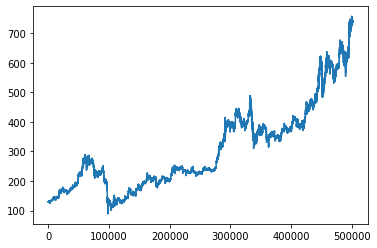

In [7]:
# Create real-time chart
my_chart = RealTimeChart('./gemini_ETHUSD_2020_1min.csv')

# Visualize the chart
my_chart.visualize()

In [8]:
# Perform benchmark run

# Create wallet for the benchmark run with 1000 units of fiat currency
my_benchmark_wallet = Wallet(1000)

# Create parameters for the benchmark run
my_benchmark_parameters = Parameters()

# Create a trader for the benchmark run and inject the wallet and the chart
my_benchmark_trader = Trader(my_benchmark_wallet, my_benchmark_parameters, my_chart)

# Create benchmark run (start with all in and sell at end of chart)
benchmark = my_benchmark_trader.run_benchmark()

----------------
FIAT:  1000
CRYP:  0 -> 0.0 FIAT
SUM:  1000.0 (FIAT)
----------------
Crypto units bought for budget of 1000 FIAT (Unit price:  128.84 )
Charge fee:  0.5 % -> 7.72275690779261 new crypto units in wallet
----------------
FIAT:  0
CRYP:  7.72275690779261 -> 995.0 FIAT
SUM:  995.0 (FIAT)
----------------
7.72275690779261 crypto units sold for unit price of 738.0 FIAT (Overall price: 5699.394597950946 FIAT)
Charge fee:  0.5 % -> 5670.8976249611915 new FIAT units in wallet
----------------
FIAT:  5670.8976249611915
CRYP:  0.0 -> 0.0 FIAT
SUM:  5670.8976249611915 (FIAT)
----------------


In [9]:
# Perform run according to a trading algorithm

# Create wallet with 1000 units of fiat currency
my_wallet = Wallet(1000)

# Create parameters for trading
my_parameters = Parameters()

# Create trader and inject the wallet and the chart
my_trader = Trader(my_wallet, my_parameters, my_chart)

# Create benchmark run (start with all in and sell at end of chart)
wallet_history = my_trader.run()

----------------
FIAT:  1000
CRYP:  0 -> 0.0 FIAT
SUM:  1000.0 (FIAT)
----------------
Crypto units bought for budget of 1000 FIAT (Unit price:  128.84 )
Charge fee:  0.5 % -> 7.72275690779261 new crypto units in wallet
Stop loss limit is at 109.514
----------------
FIAT:  0
CRYP:  7.72275690779261 -> 995.0 FIAT
SUM:  995.0 (FIAT)
----------------
Current price is 128.99  -> Increase stop loss limit to 109.64150000000001
Current price is 129.0  -> Increase stop loss limit to 109.64999999999999
Current price is 129.65  -> Increase stop loss limit to 110.2025
Current price is 129.84  -> Increase stop loss limit to 110.364
Current price is 130.01  -> Increase stop loss limit to 110.50849999999998
Current price is 130.1  -> Increase stop loss limit to 110.585
Current price is 130.23  -> Increase stop loss limit to 110.69549999999998
Current price is 130.56  -> Increase stop loss limit to 110.976
Current price is 130.57  -> Increase stop loss limit to 110.9845
Current price is 130.75  -> In

Current price is 179.77  -> Increase stop loss limit to 152.80450000000002
Current price is 180.12  -> Increase stop loss limit to 153.102
Current price is 180.25  -> Increase stop loss limit to 153.2125
Current price is 180.55  -> Increase stop loss limit to 153.4675
Current price is 180.84  -> Increase stop loss limit to 153.714
Current price is 180.86  -> Increase stop loss limit to 153.731
Current price is 180.9  -> Increase stop loss limit to 153.76500000000001
Current price is 180.91  -> Increase stop loss limit to 153.77349999999998
Current price is 181.04  -> Increase stop loss limit to 153.884
Current price is 181.22  -> Increase stop loss limit to 154.037
Current price is 181.4  -> Increase stop loss limit to 154.19
Current price is 181.45  -> Increase stop loss limit to 154.2325
Current price is 181.65  -> Increase stop loss limit to 154.4025
Current price is 181.75  -> Increase stop loss limit to 154.48749999999998
Current price is 181.75  -> Increase stop loss limit to 154

Current price is 249.31  -> Increase stop loss limit to 211.9135
Current price is 249.49  -> Increase stop loss limit to 212.0665
Current price is 249.5  -> Increase stop loss limit to 212.075
Current price is 250.48  -> Increase stop loss limit to 212.908
Current price is 250.72  -> Increase stop loss limit to 213.112
Current price is 250.84  -> Increase stop loss limit to 213.214
Current price is 250.89  -> Increase stop loss limit to 213.2565
Current price is 251.66  -> Increase stop loss limit to 213.911
Current price is 252.91  -> Increase stop loss limit to 214.9735
Current price is 253.17  -> Increase stop loss limit to 215.19449999999998
Current price is 253.56  -> Increase stop loss limit to 215.526
Current price is 254.96  -> Increase stop loss limit to 216.716
Current price is 255.52  -> Increase stop loss limit to 217.192
Current price is 256.19  -> Increase stop loss limit to 217.76149999999998
Current price is 257.45  -> Increase stop loss limit to 218.83249999999998
Curr

Current price is 263.98  -> Increase stop loss limit to 224.383
Current price is 264.54  -> Increase stop loss limit to 224.859
Current price is 264.7  -> Increase stop loss limit to 224.99499999999998
Current price is 265.62  -> Increase stop loss limit to 225.777
Current price is 266.24  -> Increase stop loss limit to 226.304
Current price is 266.46  -> Increase stop loss limit to 226.49099999999999
Current price is 266.49  -> Increase stop loss limit to 226.5165
Current price is 266.86  -> Increase stop loss limit to 226.83100000000002
Current price is 267.56  -> Increase stop loss limit to 227.426
Current price is 268.57  -> Increase stop loss limit to 228.28449999999998
Current price is 268.99  -> Increase stop loss limit to 228.6415
Current price is 269.0  -> Increase stop loss limit to 228.65
Current price is 269.67  -> Increase stop loss limit to 229.2195
Current price is 270.79  -> Increase stop loss limit to 230.1715
Current price is 271.33  -> Increase stop loss limit to 230

Current price is 220.0  -> Increase stop loss limit to 187.0
Current price is 221.61  -> Increase stop loss limit to 188.3685
Current price is 222.2  -> Increase stop loss limit to 188.86999999999998
Current price is 223.5  -> Increase stop loss limit to 189.975
Current price is 224.33  -> Increase stop loss limit to 190.6805
Current price is 224.46  -> Increase stop loss limit to 190.791
Current price is 224.75  -> Increase stop loss limit to 191.0375
Current price is 224.89  -> Increase stop loss limit to 191.1565
Current price is 225.8  -> Increase stop loss limit to 191.93
Current price is 225.84  -> Increase stop loss limit to 191.964
Current price is 226.11  -> Increase stop loss limit to 192.1935
Current price is 226.6  -> Increase stop loss limit to 192.60999999999999
Current price is 227.14  -> Increase stop loss limit to 193.069
Current price is 227.55  -> Increase stop loss limit to 193.41750000000002
Current price is 228.0  -> Increase stop loss limit to 193.79999999999998


Current price is 332.72  -> Increase stop loss limit to 282.812
Current price is 333.0  -> Increase stop loss limit to 283.05
Current price is 333.69  -> Increase stop loss limit to 283.6365
Current price is 334.0  -> Increase stop loss limit to 283.9
Current price is 335.57  -> Increase stop loss limit to 285.23449999999997
Current price is 335.72  -> Increase stop loss limit to 285.362
Current price is 337.12  -> Increase stop loss limit to 286.552
Current price is 338.4  -> Increase stop loss limit to 287.64
Current price is 339.24  -> Increase stop loss limit to 288.354
Current price is 339.67  -> Increase stop loss limit to 288.7195
Current price is 341.24  -> Increase stop loss limit to 290.054
Current price is 342.35  -> Increase stop loss limit to 290.9975
Current price is 343.48  -> Increase stop loss limit to 291.958
Current price is 343.57  -> Increase stop loss limit to 292.0345
Current price is 344.43  -> Increase stop loss limit to 292.7655
Current price is 344.65  -> Inc

Current price is 404.99  -> Increase stop loss limit to 344.2415
Current price is 405.23  -> Increase stop loss limit to 344.4455
Current price is 405.71  -> Increase stop loss limit to 344.8535
Current price is 406.77  -> Increase stop loss limit to 345.75449999999995
Current price is 407.07  -> Increase stop loss limit to 346.0095
Current price is 407.5  -> Increase stop loss limit to 346.375
Current price is 408.02  -> Increase stop loss limit to 346.81699999999995
Current price is 410.48  -> Increase stop loss limit to 348.908
Current price is 411.58  -> Increase stop loss limit to 349.84299999999996
Current price is 416.93  -> Increase stop loss limit to 354.3905
Current price is 419.67  -> Increase stop loss limit to 356.7195
Current price is 420.92  -> Increase stop loss limit to 357.782
Current price is 421.27  -> Increase stop loss limit to 358.0795
Current price is 422.81  -> Increase stop loss limit to 359.38849999999996
Current price is 426.0  -> Increase stop loss limit to

Current price is 428.25  -> Increase stop loss limit to 364.0125
Current price is 428.86  -> Increase stop loss limit to 364.531
Current price is 429.3  -> Increase stop loss limit to 364.905
Current price is 429.44  -> Increase stop loss limit to 365.024
Current price is 429.49  -> Increase stop loss limit to 365.0665
Current price is 429.5  -> Increase stop loss limit to 365.075
Current price is 430.0  -> Increase stop loss limit to 365.5
Current price is 430.08  -> Increase stop loss limit to 365.568
Current price is 431.39  -> Increase stop loss limit to 366.68149999999997
Current price is 432.1  -> Increase stop loss limit to 367.285
Current price is 432.79  -> Increase stop loss limit to 367.8715
Current price is 433.27  -> Increase stop loss limit to 368.2795
Current price is 433.65  -> Increase stop loss limit to 368.60249999999996
Current price is 434.78  -> Increase stop loss limit to 369.563
Current price is 434.82  -> Increase stop loss limit to 369.597
Current price is 435

Current price is 389.94  -> Increase stop loss limit to 331.449
Current price is 390.87  -> Increase stop loss limit to 332.2395
Current price is 391.29  -> Increase stop loss limit to 332.5965
Current price is 391.64  -> Increase stop loss limit to 332.894
Current price is 391.77  -> Increase stop loss limit to 333.00449999999995
Current price is 392.46  -> Increase stop loss limit to 333.59099999999995
Current price is 393.31  -> Increase stop loss limit to 334.3135
Current price is 393.67  -> Increase stop loss limit to 334.6195
Current price is 394.09  -> Increase stop loss limit to 334.9765
Current price is 394.23  -> Increase stop loss limit to 335.0955
Current price is 394.31  -> Increase stop loss limit to 335.1635
--- SELL SIGNAL: Stop loss limit undershoot at  2020-09-21 14:33:00 ---
7.711711052242412 crypto units sold for unit price of 335.0 FIAT (Overall price: 2583.423202501208 FIAT)
Charge fee:  0.5 % -> 2570.506086488702 new FIAT units in wallet
--- BUY SIGNAL: Price bel

Current price is 396.49  -> Increase stop loss limit to 337.0165
Current price is 396.76  -> Increase stop loss limit to 337.246
Current price is 398.83  -> Increase stop loss limit to 339.0055
Current price is 398.94  -> Increase stop loss limit to 339.099
Current price is 399.22  -> Increase stop loss limit to 339.337
Current price is 399.97  -> Increase stop loss limit to 339.97450000000003
Current price is 400.0  -> Increase stop loss limit to 340.0
Current price is 400.18  -> Increase stop loss limit to 340.153
Current price is 401.54  -> Increase stop loss limit to 341.309
Current price is 402.26  -> Increase stop loss limit to 341.921
Current price is 403.0  -> Increase stop loss limit to 342.55
Current price is 404.56  -> Increase stop loss limit to 343.876
Current price is 404.66  -> Increase stop loss limit to 343.961
Current price is 405.47  -> Increase stop loss limit to 344.6495
Current price is 406.82  -> Increase stop loss limit to 345.79699999999997
Current price is 407

Current price is 476.7  -> Increase stop loss limit to 405.195
Current price is 476.99  -> Increase stop loss limit to 405.4415
Current price is 477.77  -> Increase stop loss limit to 406.1045
Current price is 478.41  -> Increase stop loss limit to 406.6485
Current price is 478.77  -> Increase stop loss limit to 406.9545
Current price is 479.98  -> Increase stop loss limit to 407.983
Current price is 480.0  -> Increase stop loss limit to 408.0
Current price is 480.79  -> Increase stop loss limit to 408.6715
Current price is 481.34  -> Increase stop loss limit to 409.13899999999995
Current price is 481.55  -> Increase stop loss limit to 409.3175
Current price is 482.26  -> Increase stop loss limit to 409.921
Current price is 482.6  -> Increase stop loss limit to 410.21000000000004
Current price is 482.67  -> Increase stop loss limit to 410.2695
Current price is 483.5  -> Increase stop loss limit to 410.97499999999997
Current price is 483.95  -> Increase stop loss limit to 411.3574999999

--- SELL SIGNAL: Stop loss limit undershoot at  2020-11-26 03:32:00 ---
7.634786734496293 crypto units sold for unit price of 515.77 FIAT (Overall price: 3937.793954051153 FIAT)
Charge fee:  0.5 % -> 3918.104984280897 new FIAT units in wallet
--- BUY SIGNAL: Price below mean average fraction limit of 615.2799999999787 at 2020-11-26 03:32:00 ---
Crypto units bought for budget of 3918.104984280897 FIAT (Unit price:  515.77 )
Charge fee:  0.5 % -> 7.558629736819692 new crypto units in wallet
Current price is 521.69  -> Increase stop loss limit to 443.4365
Current price is 522.69  -> Increase stop loss limit to 444.28650000000005
Current price is 524.04  -> Increase stop loss limit to 445.43399999999997
Current price is 524.17  -> Increase stop loss limit to 445.54449999999997
Current price is 526.78  -> Increase stop loss limit to 447.763
Current price is 531.07  -> Increase stop loss limit to 451.40950000000004
Current price is 533.0  -> Increase stop loss limit to 453.05
Current price i

Current price is 618.49  -> Increase stop loss limit to 525.7165
Current price is 620.0  -> Increase stop loss limit to 527.0
Current price is 620.54  -> Increase stop loss limit to 527.459
Current price is 620.69  -> Increase stop loss limit to 527.5865
Current price is 622.53  -> Increase stop loss limit to 529.1505
Current price is 622.89  -> Increase stop loss limit to 529.4565
Current price is 623.67  -> Increase stop loss limit to 530.1194999999999
Current price is 623.78  -> Increase stop loss limit to 530.213
Current price is 623.84  -> Increase stop loss limit to 530.264
Current price is 624.0  -> Increase stop loss limit to 530.4
Current price is 624.1  -> Increase stop loss limit to 530.485
Current price is 624.13  -> Increase stop loss limit to 530.5105
Current price is 625.31  -> Increase stop loss limit to 531.5134999999999
Current price is 625.41  -> Increase stop loss limit to 531.5985
Current price is 625.52  -> Increase stop loss limit to 531.692
Current price is 625.

--- SELL SIGNAL: Stop loss limit undershoot at  2020-12-23 22:22:00 ---
7.483232405194916 crypto units sold for unit price of 560.0 FIAT (Overall price: 4190.610146909153 FIAT)
Charge fee:  0.5 % -> 4169.6570961746065 new FIAT units in wallet
--- BUY SIGNAL: Price below mean average fraction limit of 669.3419999999877 at 2020-12-23 22:22:00 ---
Crypto units bought for budget of 4169.6570961746065 FIAT (Unit price:  560.0 )
Charge fee:  0.5 % -> 7.408587161953095 new crypto units in wallet
Current price is 564.46  -> Increase stop loss limit to 479.791
Current price is 567.36  -> Increase stop loss limit to 482.256
Current price is 578.0  -> Increase stop loss limit to 491.3
Current price is 582.02  -> Increase stop loss limit to 494.717
Current price is 582.77  -> Increase stop loss limit to 495.3545
Current price is 583.69  -> Increase stop loss limit to 496.1365
Current price is 586.18  -> Increase stop loss limit to 498.25299999999993
Current price is 586.88  -> Increase stop loss l

Current price is 732.75  -> Increase stop loss limit to 622.8375
Current price is 735.99  -> Increase stop loss limit to 625.5915
Current price is 737.44  -> Increase stop loss limit to 626.8240000000001
Current price is 737.73  -> Increase stop loss limit to 627.0705
Current price is 739.46  -> Increase stop loss limit to 628.541
Current price is 739.58  -> Increase stop loss limit to 628.643
Current price is 741.77  -> Increase stop loss limit to 630.5045
Current price is 742.61  -> Increase stop loss limit to 631.2185
Current price is 743.95  -> Increase stop loss limit to 632.3575000000001
Current price is 744.1  -> Increase stop loss limit to 632.485
Current price is 745.73  -> Increase stop loss limit to 633.8705
Current price is 746.15  -> Increase stop loss limit to 634.2275
Current price is 746.6  -> Increase stop loss limit to 634.61
Current price is 746.71  -> Increase stop loss limit to 634.7035
Current price is 746.94  -> Increase stop loss limit to 634.899
Current price i

In [10]:
print("Benchmark growth")
calc_growth(benchmark)
print("---")
print("Wallet growth")
calc_growth(wallet_history)

Benchmark growth
Open: 1000.0
Close: 5699.394597950946
Growth: 469.939 %
---
Wallet growth
Open: 1000.0
Close: 5467.537325521384
Growth: 446.754 %


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


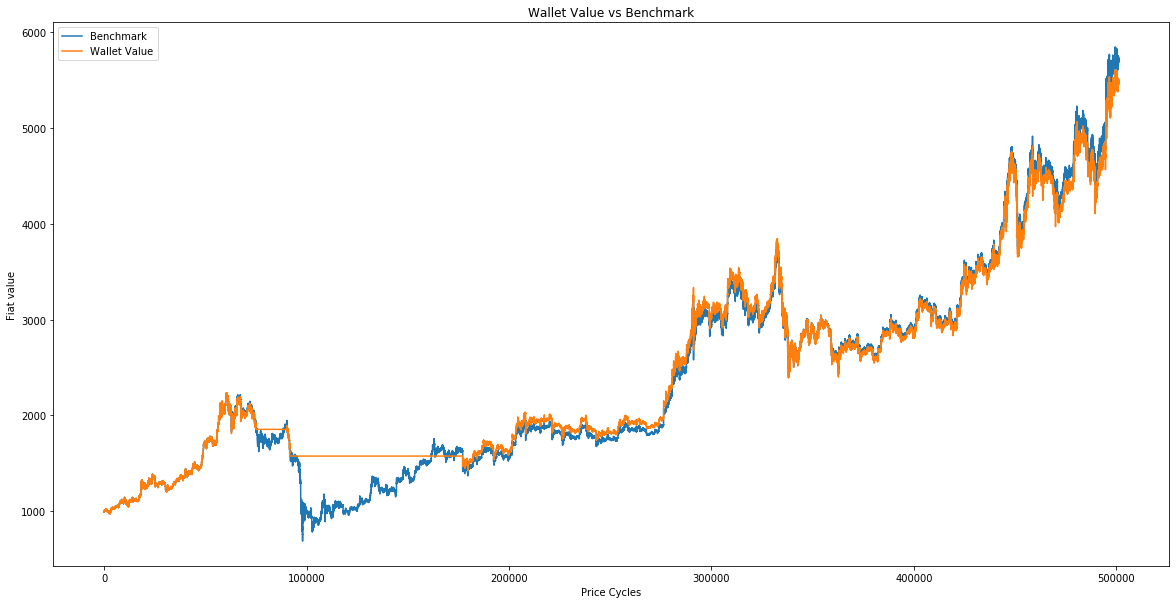

In [11]:
# Plot benchmark and wallet history in one chart
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(benchmark['Wallet_Value'], label="Benchmark")
plt.plot(wallet_history['Wallet_Value'], label="Wallet Value")
plt.xlabel('Price Cycles')
plt.ylabel('Fiat value')
plt.title('Wallet Value vs Benchmark')
plt.legend()
plt.show()